In [337]:
import pandas as pd
import numpy as np
import os 
print(os.getcwd())
def read_file(file_path='end2end_new/goodput_vs_num_devices.tsv'):
    df = pd.read_csv(file_path, sep='\t')
    # 设置df的列名
    # df.columns = ["exp_name", "num_models",
    #            "num_devices", "num_devices_per_node", "mem_budget", "total_rate", "rate_distribution",
    #            "arrival_process", "arrival_process_kwargs", "slo_scale", "duration",
    #            "policy_name", "placement", "goodput", "mode", "solver_time"]
    return df
df = read_file()

/home/zy/python_project/mms/hpsc25_artifact/end2end


In [338]:
policies = df['policy_name'].unique()
policies

array(['mp-search-sep', 'sr-replace-600', 'dqn-dynamic'], dtype=object)

In [339]:
df.head()

,exp_name,num_models,model_groups_num,num_devices,num_devices_per_node,mem_budget,total_rate,rate_distribution,arrival_process,arrival_process_kwargs,slo_scale,duration,policy_name,placement,goodput,mode,solver_time
0,goodput_vs_num_devices,12,2,4,4,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 4, 'trace_di...",5,3600,mp-search-sep,ModelPlacement(group_configs=(ParallelConfig(d...,0.282,simulate,6.195
1,goodput_vs_num_devices,12,2,4,4,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 4, 'trace_di...",5,3600,sr-replace-600,ModelPlacementWithReplacement(num_segments=6),0.268,simulate,0.268
2,goodput_vs_num_devices,12,2,8,4,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 4, 'trace_di...",5,3600,mp-search-sep,ModelPlacement(group_configs=(ParallelConfig(d...,0.568,simulate,6.935
3,goodput_vs_num_devices,12,2,8,4,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 4, 'trace_di...",5,3600,sr-replace-600,ModelPlacementWithReplacement(num_segments=6),0.519,simulate,0.401
4,goodput_vs_num_devices,12,2,12,4,13958643712,-1,NaN,azure_v1,"{'rate_scale': 0.005, 'cv_scale': 4, 'trace_di...",5,3600,mp-search-sep,ModelPlacement(group_configs=(ParallelConfig(d...,0.777,simulate,4.632


输出图表到 goodput_vs_num_devices.png


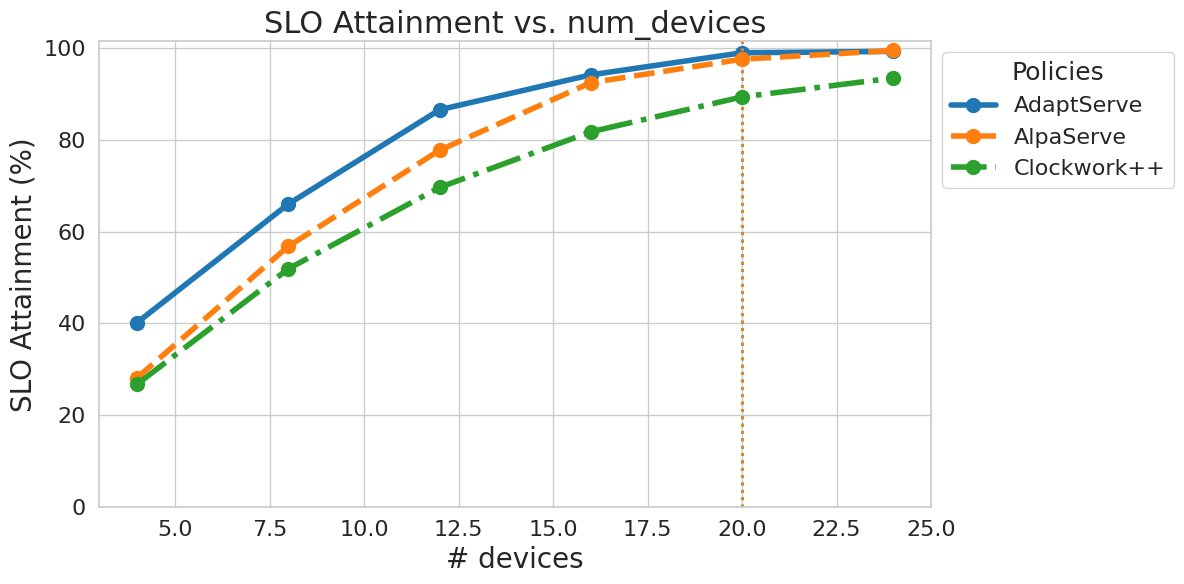

输出图表到 goodput_vs_num_devices.png


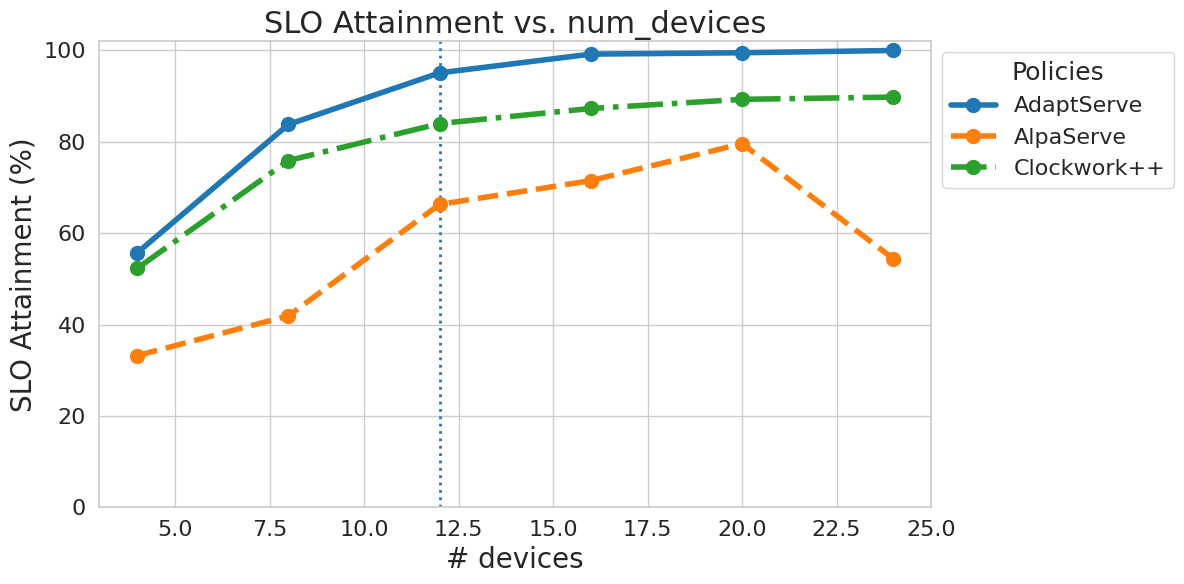

In [340]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np

def method2order(method):
    # 定义方法的排序逻辑
    order = {
        "dqn-dynamic": 1,
        "mp-search-sep": 2,
        "sr-replace-600": 3,
        # 添加其他策略
    }
    return order.get(method, 99)

def show_name(method):
    # 定义方法的显示名称
    names = {
        "dqn-dynamic": "AdaptServe",
        "mp-search-sep": "AlpaServe",
        "sr-replace-600": "Clockwork++",
        # 添加其他策略名称
    }
    return names.get(method, method)

# 定义颜色和线型
methodcolors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
linestyles = ['-', '--', '-.', ':', '-', '--']

def plot_goodput_vs_target(df, policies, target, arrival_process, threshold=0.95, increasing=True, xlabel='Target Variable', output='goodput_plot.png', ybottom=0, plot_legend=False):
    """
    绘制不同策略下 Goodput 随目标变量变化的折线图，风格参考 plot_goodput_common。

    参数:
    df : DataFrame - 包含政策、目标变量和 Goodput 的数据框。
    policies : list - 策略名称列表。
    target : str - 变量目标名。
    arrival_process : str - 数据名称。
    threshold : float - SLO 达成的阈值，默认0.8。
    increasing : bool - 目标变量是递增还是递减，默认True。
    xlabel : str - X轴标签，默认'Target Variable'。
    output : str - 输出图片文件名，默认'goodput_plot.png'。
    ybottom : float - Y轴下限，默认0。
    plot_legend : bool - 是否在子图中显示标题，默认False。
    """
    # 设置整体风格
    sns.set(style="whitegrid")
    
    # 提取目标变量
    if target in ast.literal_eval(df['arrival_process_kwargs'].iloc[0]).keys():
        df[target] = df['arrival_process_kwargs'].apply(lambda x: ast.literal_eval(x)[target])

    target_list = sorted(df[target].unique())
    
    # 计算每个策略和目标的 goodput，并乘以100
    goodput_dict = {policy: [] for policy in policies}
    first_good = {policy: 0 for policy in policies}
    x_max = 0
    y_max = 0

    for policy in policies:
        for t in target_list:
            df_policy_target = df[(df.policy_name == policy) & (df[target] == t) & (df.arrival_process == arrival_process)]
            mean_goodput = df_policy_target.goodput.mean() * 100  # 转换为百分比
            goodput_dict[policy].append(mean_goodput)
        
        # 查找首次达到阈值的位置
        ys = np.array(goodput_dict[policy])
        if increasing:
            indices = range(len(ys))
        else:
            indices = reversed(range(len(ys)))
        
        for i in indices:
            if ys[i] >= threshold * 100:
                first_good[policy] = target_list[i]
                break

        x_max = max(x_max, max(target_list))
        y_max = max(y_max, max(ys))
    
    # 创建子图
    fig, ax = plt.subplots(figsize=(20, 10))

    # 绘制每个策略的曲线
    curves = []
    legends = []
    for i, policy in enumerate(sorted(policies, key=lambda x: method2order(x))):
        ax.plot(target_list, goodput_dict[policy], 
                color=methodcolors[i % len(methodcolors)], 
                linestyle=linestyles[i % len(linestyles)], 
                marker='o', linewidth=4, markersize=10, label=show_name(policy))
        curves.append(ax.lines[-1])
        legends.append(show_name(policy))
        
        # 添加阈值垂直线
        if first_good[policy] != 0:
            ax.axvline(first_good[policy], color=methodcolors[i % len(methodcolors)], linestyle=":", linewidth=2)

    # 设置轴标签和标题
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel("SLO Attainment (%)", fontsize=20)
    ax.set_title(f"SLO Attainment vs. {target}", fontsize=22)
    
    # 设置刻度字体大小
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    
    # 设置Y轴范围
    ax.set_ylim(bottom=ybottom, top=max(y_max * 1.02, 100))
    
    # 添加网格
    ax.grid(True)
    
    # 添加图例
    if plot_legend:
        ax.legend(curves, legends, title="Policies", fontsize=16, title_fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))
    else:
        ax.legend().remove()
    
    # 保存并显示图形
    fig.set_size_inches(12, 6)
    plt.tight_layout()
    plt.savefig(output, bbox_inches='tight')
    print(f"输出图表到 {output}")
    plt.show()

# 示例用法：
policies = ['mp-search-sep', 'sr-replace-600', 'dqn-dynamic']
plot_goodput_vs_target(df, policies, 'num_devices', 'azure_v1', plot_legend=True, xlabel='# devices', output='goodput_vs_num_devices.png')
plot_goodput_vs_target(df, policies, 'num_devices', 'azure_v2', plot_legend=True, xlabel='# devices', output='goodput_vs_num_devices.png')

输出图表到 goodput_device.pdf


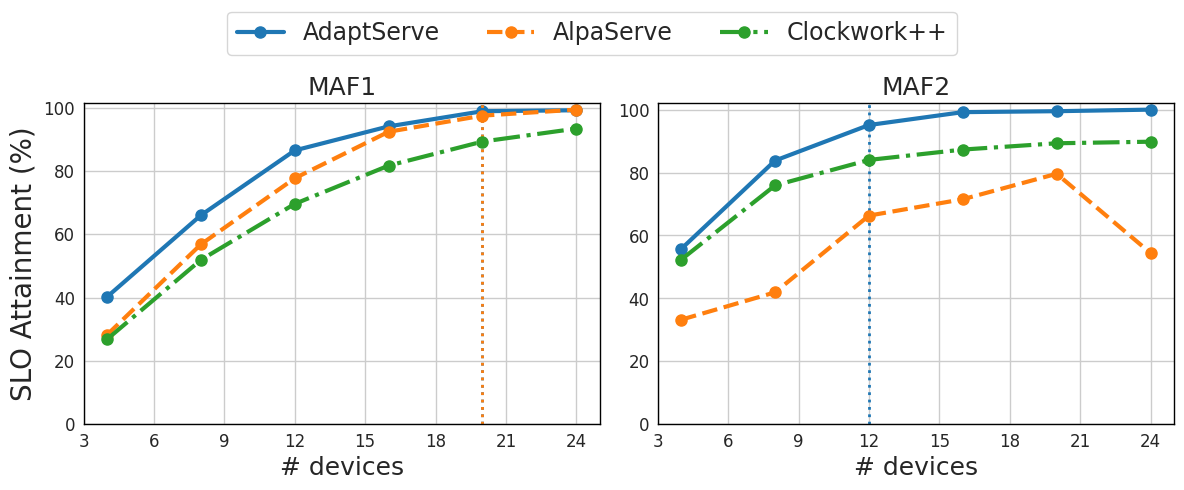

In [341]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker

def method2order(method):
    # 定义方法的排序逻辑
    order = {
        "dqn-dynamic": 1,
        "mp-search-sep": 2,
        "sr-replace-600": 3,
        # 添加其他策略
    }
    return order.get(method, 99)

def show_name(method):
    # 定义方法的显示名称
    names = {
        "dqn-dynamic": "AdaptServe",
        "mp-search-sep": "AlpaServe",
        "sr-replace-600": "Clockwork++",
        # 添加其他策略名称
    }
    return names.get(method, method)

# 定义颜色和线型
methodcolors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
linestyles = ['-', '--', '-.', ':', '-', '--']

def plot_goodput_comparison(df, policies, target, arrival_process_list, threshold=0.95, increasing=True, xlabel='Target Variable', output='goodput_comparison.png', ybottom=0, plot_legend=True):
    """
    绘制多个 arrival_process 下不同策略的 Goodput 随目标变量变化的并列折线图，并将图例放在上方。

    参数:
    df : DataFrame - 包含政策、目标变量和 Goodput 的数据框。
    policies : list - 策略名称列表。
    target : str - 变量目标名。
    arrival_process_list : list - 多个 arrival_process 名称列表。
    threshold : float - SLO 达成的阈值，默认0.95。
    increasing : bool - 目标变量是递增还是递减，默认True。
    xlabel : str - X轴标签，默认'Target Variable'。
    output : str - 输出图片文件名，默认'goodput_comparison.png'。
    ybottom : float - Y轴下限，默认0。
    plot_legend : bool - 是否显示图例，默认True。
    """
    # 设置整体风格
    sns.set(style="whitegrid")
    
    # 提取目标变量
    if target in ast.literal_eval(df['arrival_process_kwargs'].iloc[0]).keys():
        df[target] = df['arrival_process_kwargs'].apply(lambda x: ast.literal_eval(x)[target])
    
    target_list = sorted(df[target].unique())
    
    num_processes = len(arrival_process_list)
    
    # 调整每个子图的宽度，例如每个子图宽6英寸
    fig_width = 6 * num_processes
    fig, axes = plt.subplots(1, num_processes, figsize=(fig_width, 5), sharey=False)
    
    # 如果只有一个 arrival_process，则 axes 不是列表，需要转换为列表
    if num_processes == 1:
        axes = [axes]
    
    # 用于收集所有曲线和标签以创建统一的图例
    all_curves = []
    all_legends = []
    
    for ax, arrival_process in zip(axes, arrival_process_list):
        # 计算每个策略和目标的 goodput，并乘以100
        goodput_dict = {policy: [] for policy in policies}
        first_good = {policy: 0 for policy in policies}
        x_max = 0
        y_max = 0
        
        for policy in policies:
            for t in target_list:
                df_policy_target = df[(df.policy_name == policy) & (df[target] == t) & (df.arrival_process == arrival_process)]
                mean_goodput = df_policy_target.goodput.mean() * 100  # 转换为百分比
                goodput_dict[policy].append(mean_goodput)
            
            # 查找首次达到阈值的位置
            ys = np.array(goodput_dict[policy])
            if increasing:
                indices = range(len(ys))
            else:
                indices = reversed(range(len(ys)))
            
            for i in indices:
                if ys[i] >= threshold * 100:
                    first_good[policy] = target_list[i]
                    break
            
            x_max = max(x_max, max(target_list))
            y_max = max(y_max, max(ys))
        
        # 绘制每个策略的曲线
        for i, policy in enumerate(sorted(policies, key=lambda x: method2order(x))):
            curve, = ax.plot(target_list, goodput_dict[policy], 
                            color=methodcolors[i % len(methodcolors)], 
                            linestyle=linestyles[i % len(linestyles)], 
                            marker='o', linewidth=3, markersize=8, label=show_name(policy))
            if arrival_process == arrival_process_list[0]:  # 仅收集一次图例
                all_curves.append(curve)
                all_legends.append(show_name(policy))
            
            # 添加阈值垂直线
            if first_good[policy] != 0:
                ax.axvline(first_good[policy], color=methodcolors[i % len(methodcolors)], linestyle=":", linewidth=2)

            # 只在第一个子图显示y轴标签
            if ax == axes[0]:
                ax.set_ylabel("SLO Attainment (%)", fontsize=20)


        
        # 设置轴标签和标题
        ax.set_xlabel(xlabel, fontsize=18)
        # ax.set_ylabel("SLO Attainment (%)", fontsize=14)  # 每个子图显示 y 轴标签
        if arrival_process == 'azure_v1':
            ax.set_title("MAF1", fontsize=18)
        elif arrival_process == 'azure_v2':
            ax.set_title("MAF2", fontsize=18)
        elif arrival_process == 'online':
            ax.set_title("Synthetic", fontsize=18)
        
        # 设置刻度字体大小
        ax.tick_params(axis='both', which='major', labelsize=12, pad=0)
        ax.tick_params(axis='both', which='minor', labelsize=12, pad=0)
        
        # 设置Y轴范围
        ax.set_ylim(bottom=ybottom, top=max(y_max * 1.02, 100))

        # 设置X轴为整数刻度
        if target == 'num_devices':  # 针对num_devices设置X轴为整数
            ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
        # 添加网格
        ax.grid(True)

        # 确保边框可见
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)  # 设置边框线宽
            spine.set_color('black')  # 设置边框颜色
    
    # 设置共同的Y轴标签（可选，如果每个子图都有自己的 y 标签，可以移除此行）
    # fig.text(0.04, 0.5, "SLO Attainment (%)", va='center', rotation='vertical', fontsize=16)
    
    # 添加统一的图例在上方
    if plot_legend:
        fig.legend(all_curves, all_legends, fontsize=17, title_fontsize=18, loc='upper center', ncol=len(policies))
    
    # 调整布局，为图例留出空间
    plt.tight_layout(rect=[0, 0, 1, 0.88])  # 为图例留出顶部空间
    fig.set_size_inches(fig_width, 5)
    
    # 保存并显示图形
    plt.savefig(output, bbox_inches='tight', dpi=300)  # 增加 dpi 提高清晰度
    print(f"输出图表到 {output}")
    plt.show()

# 示例用法：
# 假设您有一个 DataFrame `df` 和一个策略列表 `policies`
# df = pd.DataFrame({...})
# policies = ['policy1', 'policy2', 'policy3']

# 调用函数绘制比较图
plot_goodput_comparison(
    df=df, 
    policies=['mp-search-sep', 'dqn-dynamic', 'sr-replace-600'],
    target='num_devices', 
    arrival_process_list=['azure_v1', 'azure_v2'],
    threshold=0.95, 
    increasing=True, 
    xlabel='# devices', 
    output='goodput_device.pdf', 
    ybottom=0, 
    plot_legend=True
)


输出图表到 goodput_rate.pdf


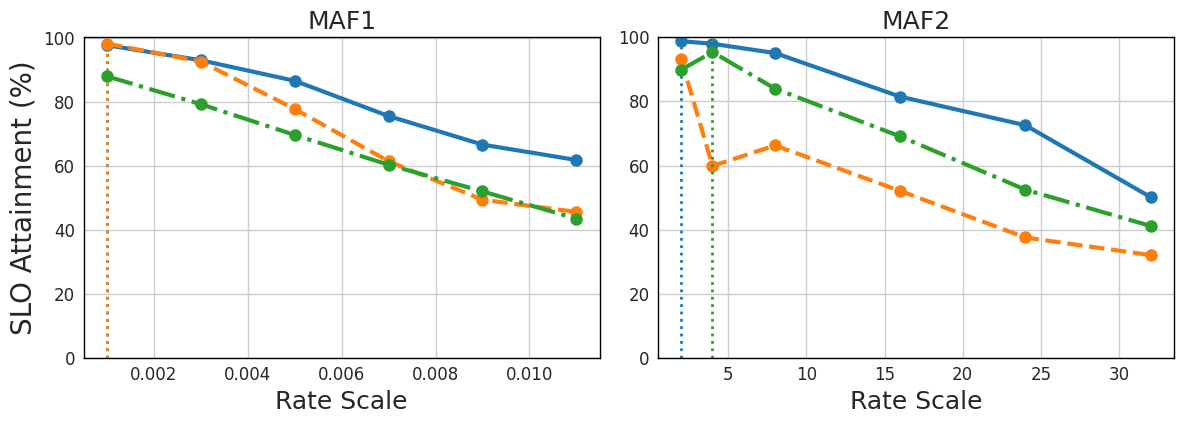

In [342]:
rate_df = read_file('end2end_new/goodput_vs_rate.tsv')
plot_goodput_comparison(
    df=rate_df, 
    policies=['mp-search-sep', 'dqn-dynamic', 'sr-replace-600'],
    target='rate_scale', 
    arrival_process_list=['azure_v1', 'azure_v2'], 
    threshold=0.95, 
    increasing=True, 
    xlabel='Rate Scale', 
    output='goodput_rate.pdf', 
    ybottom=0, 
    plot_legend=False
)

输出图表到 goodput_cv.pdf


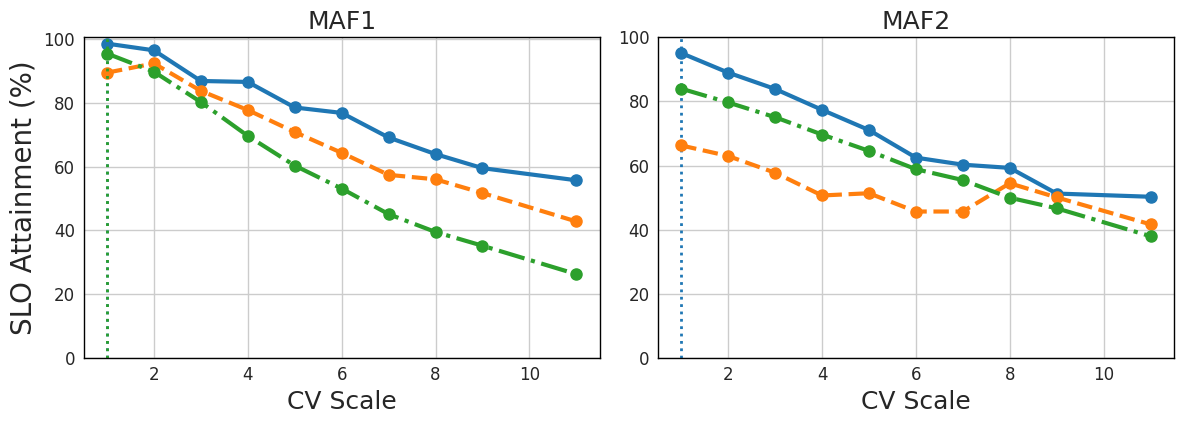

In [343]:
cv_df = read_file('end2end_new/goodput_vs_cv.tsv')
plot_goodput_comparison(
    df=cv_df, 
    policies=['mp-search-sep', 'dqn-dynamic', 'sr-replace-600'],
    target='cv_scale', 
    arrival_process_list=['azure_v1', 'azure_v2'], 
    threshold=0.95, 
    increasing=True, 
    xlabel='CV Scale', 
    output='goodput_cv.pdf', 
    ybottom=0, 
    plot_legend=False
)

输出图表到 goodput_slo.pdf


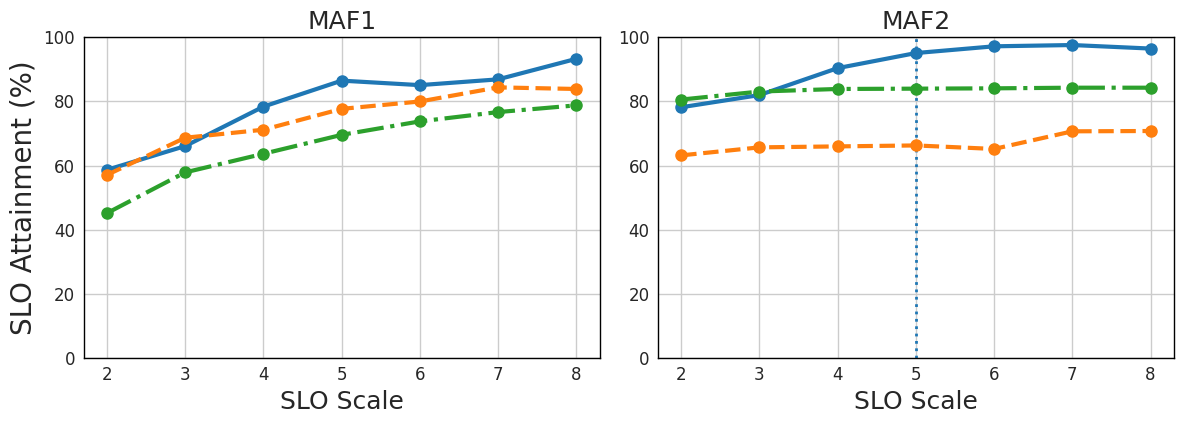

In [344]:
slo_df = read_file('end2end_new/goodput_vs_slo.tsv')
plot_goodput_comparison(
    df=slo_df, 
    policies=['mp-search-sep', 'dqn-dynamic', 'sr-replace-600'],
    target='slo_scale', 
    arrival_process_list=['azure_v1', 'azure_v2'], 
    threshold=0.95, 
    increasing=True, 
    xlabel='SLO Scale', 
    output='goodput_slo.pdf', 
    ybottom=0, 
    plot_legend=False
)

azure_v1 dqn-dynamic [0.513, 0.692, 0.004, 0.145, 0.002, 0.019]
azure_v1 sr-replace-600 [0.268, 0.401, 0.587, 0.774, 1.034, 1.293]
azure_v2 dqn-dynamic [0.153, 0.149, 0.175, 0.112, 0.011, 0.002]
azure_v2 sr-replace-600 [0.0725, 0.1505, 0.254, 0.368, 0.5085, 0.6655]
输出图表到 solver_time_comparison_bar.pdf


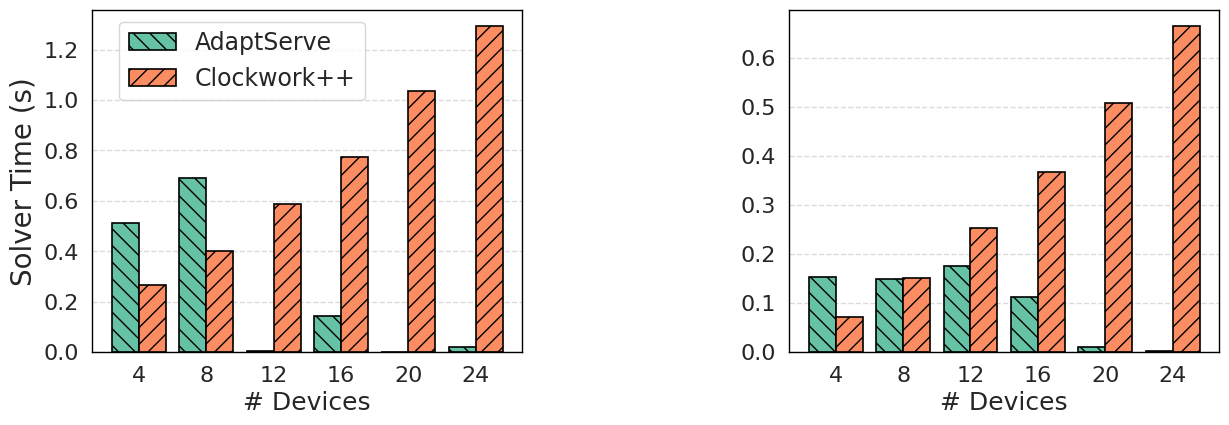

In [345]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
import pandas as pd

def method2order(method):
    # 定义方法的排序逻辑
    order = {
        "dqn-dynamic": 1,
        "mp-search-sep": 2,
        "sr-replace-600": 3,
        # 添加其他策略
    }
    return order.get(method, 99)

def show_name(method):
    # 定义方法的显示名称
    names = {
        "dqn-dynamic": "AdaptServe",
        "mp-search-sep": "AlpaServe",
        "sr-replace-600": "Clockwork++",
        # 添加其他策略名称
    }
    return names.get(method, method)
    

# 定义颜色和填充样式
# 使用颜色盲友好调色板
methodcolors = sns.color_palette("Set2", 10)  # 根据需要调整数量
# 增加填充样式的密度和差异性
methodhatches = ['/\/\/', '\\\\', '|||', '---', '+++', 'xxx', 'ooo', 'OOO', '...', '***']  # 更密集和差异化的填充样式
methodhatches = ['\\\\', '//']

def plot_time_comparison_bar(df, policies, target, arrival_process_list, xlabel='Target Variable', output='solver_time_comparison_bar.png', ybottom=0, plot_legend=True, fig_size=(10, 6)):
    """
    绘制多个 arrival_process 下不同策略的 Solver Time 随目标变量变化的柱状图，并将图例放在上方。

    参数:
    df : DataFrame - 包含政策、目标变量和 Solver Time 的数据框。
    policies : list - 策略名称列表。
    target : str - 变量目标名。
    arrival_process_list : list - 多个 arrival_process 名称列表。
    xlabel : str - X轴标签，默认'Target Variable'。
    output : str - 输出图片文件名，默认'solver_time_comparison_bar.png'。
    ybottom : float - Y轴下限，默认0。
    plot_legend : bool - 是否显示图例，默认True。
    fig_size : tuple - 图表的大小，默认为 (10, 6)。
    """
    # 设置整体风格
    sns.set(style="whitegrid")

    # 提取目标变量
    if target in ast.literal_eval(df['arrival_process_kwargs'].iloc[0]).keys():
        df[target] = df['arrival_process_kwargs'].apply(lambda x: ast.literal_eval(x)[target])

    target_list = sorted(df[target].unique())

    num_processes = len(arrival_process_list)

    # 调整每个子图的宽度，例如每个子图宽8英寸
    fig_width = 8 * num_processes
    fig, axes = plt.subplots(1, num_processes, figsize=fig_size, sharey=False)

    # 如果只有一个 arrival_process，则 axes 不是列表，需要转换为列表
    if num_processes == 1:
        axes = [axes]

    # 用于收集所有柱状图和标签以创建统一的图例
    all_bars = []
    all_legends = []

    # 定义每组柱状图的宽度和位置
    bar_width = 0.8 / len(policies)  # 让所有策略的柱状图总宽度不超过0.8
    x = np.arange(len(target_list))  # 目标变量的位置

    for ax, arrival_process in zip(axes, arrival_process_list):
        # 计算每个策略和目标的 Solver Time
        solver_time_dict = {policy: [] for policy in policies}
        y_max = 0

        for policy in policies:
            for t in target_list:
                df_policy_target = df[(df.policy_name == policy) & (df[target] == t) & (df.arrival_process == arrival_process)]
                if not df_policy_target.empty:
                    mean_solver_time = df_policy_target.solver_time.mean()
                else:
                    mean_solver_time = np.nan  # 使用 NaN 表示缺失数据
                solver_time_dict[policy].append(mean_solver_time)

            # 更新 y_max
            current_max = max([val for val in solver_time_dict[policy] if not np.isnan(val)] + [0])
            y_max = max(y_max, current_max)

        # 绘制每个策略的柱状图
        for i, policy in enumerate(sorted(policies, key=lambda x: method2order(x))):
            # 计算每个柱的位置
            offset = (i - len(policies)/2) * bar_width + bar_width/2
            bar_positions = x + offset

            # 提取当前策略的 Solver Time 数据
            solver_time_values = solver_time_dict[policy]

            # 绘制柱状图，处理缺失数据
            bars = ax.bar(bar_positions, 
                          [val if not np.isnan(val) else 0 for val in solver_time_values],
                          width=bar_width,
                          color=methodcolors[i % len(methodcolors)],
                          hatch=methodhatches[i % len(methodhatches)],
                          label=show_name(policy),
                          edgecolor='black',
                          linewidth=1.2)
            # 打印时间
            print(f"{arrival_process} {policy} {solver_time_values}")

            # 记录图例
            if arrival_process == arrival_process_list[0]:
                all_bars.append(bars[0])
                all_legends.append(show_name(policy))

            # 添加“×”标记表示缺失数据，稍微上移避免与 x 轴重叠
            for j, val in enumerate(solver_time_values):
                if np.isnan(val):
                    # 将“×”标记放置在 y=5% 的位置，确保不与 x 轴重叠
                    ax.plot(bar_positions[j], ybottom + (y_max * 0.05), marker='x', color='brown', markersize=10, markeredgewidth=2)

        # 设置轴标签和标题
        ax.set_xlabel(xlabel, fontsize=18)

        # 仅在第一个子图显示y轴标签
        if ax == axes[0]:
            ax.set_ylabel("Solver Time (s)", fontsize=20)

        # 设置标题
        # if arrival_process == 'azure_v1':
        #     ax.set_title("MAF1", fontsize=18, pad=3)
        # elif arrival_process == 'azure_v2':
        #     ax.set_title("MAF2", fontsize=18, pad=3)
        # else:
        #     ax.set_title(show_name(arrival_process), fontsize=16, pad=3)

        # 设置x轴刻度
        ax.set_xticks(x)
        ax.set_xticklabels(target_list, fontsize=16)

        # 设置y轴刻度
        ax.tick_params(axis='y', which='major', labelsize=16)

        # 设置Y轴范围
        # ax.set_ylim(bottom=ybottom, top=max(y_max * 1.10, 100))  # 增加10%空间

        # 仅显示横向网格线
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

        # 移除竖向网格线
        ax.grid(False, axis='x')

        # 确保边框可见
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)  # 设置边框线宽
            spine.set_color('black')  # 设置边框颜色

    # 添加统一的图例在图内左上角
    if plot_legend:
        fig.legend(all_bars, all_legends, fontsize=17, title_fontsize=18, loc='upper left', bbox_to_anchor=(0.26, 0.84))

    # 调整布局，为图例留出空间
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # 为图例留出顶部空间
    fig.set_size_inches(fig_width, 6)

    # 保存并显示图形
    plt.savefig(output, bbox_inches='tight', dpi=600)  # 增加 dpi 提高清晰度
    print(f"输出图表到 {output}")
    plt.show()

# 示例用法：  
# 调用函数绘制比较图
df = read_file()
plot_time_comparison_bar(
    df=df, 
    policies=['sr-replace-600', 'dqn-dynamic'], # 'mp-search-sep',
    target='num_devices', 
    arrival_process_list=['azure_v1', 'azure_v2'], 
    xlabel='# Devices', 
    output='solver_time_comparison_bar.pdf', 
    ybottom=0, 
    plot_legend=True,
    fig_size=(4, 3)  # 这里可以自定义图片大小
)


In [346]:
import numpy as np

azure_v1_dqn_dynamic = [0.513, 0.692, 0.004, 0.145, 0.002, 0.019]
azure_v1_sr_replace_600 = [0.268, 0.401, 0.587, 0.774, 1.034, 1.293]
azure_v2_dqn_dynamic = [0.153, 0.149, 0.175, 0.112, 0.011, 0.002]
azure_v2_sr_replace_600 = [0.0725, 0.1505, 0.254, 0.368, 0.5085, 0.6655]

# azure_v1_sr-replace-600和azure_v2_sr-replace-600里面每个元素乘6
azure_v1_sr_replace_600 = [x * 6 for x in azure_v1_sr_replace_600]
azure_v2_sr_replace_600 = [x * 6 for x in azure_v2_sr_replace_600]

# 求出azure_v1_sr_replace_600和azure_v2_sr_replace_600对应位置元素的平均数和标准差
sr_replace_600_mean = [(azure_v1_sr_replace_600[i] + azure_v2_sr_replace_600[i]) / 2 for i in range(len(azure_v1_sr_replace_600))]
sr_replace_600_std = [np.sqrt(((azure_v1_sr_replace_600[i] - sr_replace_600_mean[i])**2 + (azure_v2_sr_replace_600[i] - sr_replace_600_mean[i])**2) / 2) for i in range(len(azure_v1_sr_replace_600))]

print("SR Replace 600 Mean:", sr_replace_600_mean)
print("SR Replace 600 Standard Deviation:", sr_replace_600_std)

# 求出azure_v1_dqn_dynamic和azure_v2_dqn_dynamic对应位置元素的平均数和标准差
dqn_dynamic_mean = [(azure_v1_dqn_dynamic[i] + azure_v2_dqn_dynamic[i]) / 2 for i in range(len(azure_v1_dqn_dynamic))]
dqn_dynamic_std = [np.sqrt(((azure_v1_dqn_dynamic[i] - dqn_dynamic_mean[i])**2 + (azure_v2_dqn_dynamic[i] - dqn_dynamic_mean[i])**2) / 2) for i in range(len(azure_v1_dqn_dynamic))]

print("DQN Dynamic Mean:", dqn_dynamic_mean)
print("DQN Dynamic Standard Deviation:", dqn_dynamic_std)


SR Replace 600 Mean: [1.0215, 1.6545, 2.5229999999999997, 3.426, 4.6275, 5.8755]
SR Replace 600 Standard Deviation: [0.5865000000000001, 0.7515000000000001, 0.9989999999999999, 1.218, 1.5765000000000007, 1.8824999999999996]
DQN Dynamic Mean: [0.333, 0.4205, 0.0895, 0.1285, 0.0065, 0.010499999999999999]
DQN Dynamic Standard Deviation: [0.18, 0.27149999999999996, 0.08549999999999999, 0.016499999999999994, 0.0045, 0.008499999999999999]


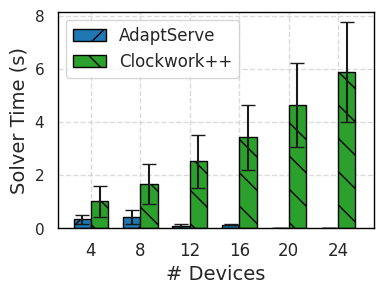

In [347]:
import matplotlib.pyplot as plt
import numpy as np

# 数据

window_size = [4, 8, 12, 16, 20, 24]
dqn_slo_attainment = dqn_dynamic_mean
sr_slo_attainment = sr_replace_600_mean

# 假设的标准差数据（示例，您可以用真实数据替换）
dqn_std_dev = dqn_dynamic_std
sr_std_dev = sr_replace_600_std

# 绘制柱状图
plt.figure(figsize=(4, 3.1))

bar_width = 0.35  # 设置柱宽度
index = np.arange(len(window_size))  # x 轴位置

# 绘制 DQN 和 SR 的柱状图，设置适当的偏移量
plt.bar(index, dqn_slo_attainment, bar_width, label="AdaptServe", color='tab:blue', hatch='/', edgecolor='black', yerr=dqn_std_dev, capsize=5)
plt.bar(index + bar_width, sr_slo_attainment, bar_width, label="Clockwork++", color='tab:green', hatch='\\', edgecolor='black', yerr=sr_std_dev, capsize=5)

# 设置标签和标题
plt.xlabel("# Devices", fontsize=14)
plt.ylabel("Solver Time (s)", fontsize=14)

# 设置图例
plt.legend(loc='upper left', fontsize=12)

# 设置网格
plt.grid(True, linestyle='--', alpha=0.7)

# 设置 x 和 y 轴范围
plt.xlim(-0.5, len(window_size) - 0.1)  # 调整x轴范围

# 设置 x 轴刻度
plt.xticks(index + bar_width / 2, window_size, fontsize=12)

# 确保边框可见
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)  # 设置边框线宽
    spine.set_color('black')  # 设置边框颜色

# 调整布局
plt.tight_layout()

# 保存图形
plt.savefig('solver_time_comparison_bar.pdf')

# 显示图形
plt.show()


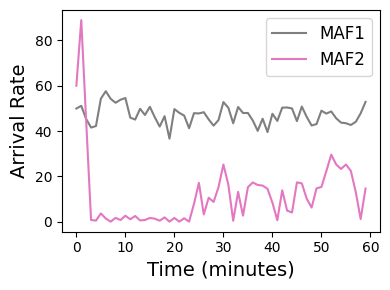

In [15]:
import matplotlib.pyplot as plt
def plot_all_models_requests(arrival_rate_v1, arrival_rate_v2):

    # 绘制所有模型的总请求数折线图
    plt.figure(figsize=(4, 3))
    plt.plot(arrival_rate_v1, label="Total requests", color="tab:gray")
    plt.plot(arrival_rate_v2, label="Total requests", color="tab:pink")

    # 设置图表标题和标签
    # plt.title("Total Requests for All Models", fontsize=16)
    plt.xlabel("Time (minutes)", fontsize=14)
    plt.ylabel("Arrival Rate", fontsize=14)
    plt.legend(["MAF1", "MAF2"], fontsize=12)

    # 调整布局并显示图表
    plt.tight_layout()
    
    # 保存图表为 PDF 文件
    plt.savefig("all_models_requests_rate.pdf")

    # 显示图表
    plt.show()

azure_v1 = [
    49.93333333, 51.13333333, 45.33333333, 41.53333333, 42.2,
    54.28333333, 57.58333333, 54.21666667, 52.48333333, 53.81666667,
    54.58333333, 45.93333333, 45.05, 49.81666667, 47.08333333,
    50.7, 46.1, 41.96666667, 46.55, 36.63333333,
    49.68333333, 48.03333333, 46.81666667, 41.25, 47.88333333,
    47.76666667, 48.31666667, 45.11666667, 42.38333333, 44.85,
    52.78333333, 50.31666667, 43.43333333, 50.61666667, 47.96666667,
    47.96666667, 44.65, 40.08333333, 45.43333333, 39.55,
    47.61666667, 44.46666667, 50.31666667, 50.4, 49.96666667,
    44.38333333, 50.8, 46.23333333, 42.45, 43.06666667,
    48.98333333, 47.7, 48.65, 45.65, 43.71666667,
    43.45, 42.66666667, 44.05, 47.8, 52.86666667
]
azure_v2 = [
    60.0, 88.98333333, 44.5, 0.75, 0.45,
    3.63333333, 1.38333333, 0.0, 1.66666667, 0.71666667,
    2.61666667, 1.05, 2.5, 0.55, 0.71666667,
    1.65, 1.3, 0.41666667, 1.88333333, 0.0,
    1.63333333, 0.0, 1.48333333, 0.0, 7.86666667,
    17.15, 3.18333333, 10.56666667, 8.7, 15.2,
    25.21666667, 16.41666667, 0.4, 13.15, 2.63333333,
    15.21666667, 17.3, 16.18333333, 15.91666667, 14.5,
    8.36666667, 0.61666667, 13.85, 4.86666667, 4.03333333,
    17.33333333, 16.88333333, 10.11666667, 6.21666667, 14.68333333,
    15.33333333, 22.3, 29.58333333, 25.28333333, 23.25,
    25.23333333, 22.43333333, 13.11666667, 1.15, 14.61666667
]
plot_all_models_requests(azure_v1, azure_v2)